# Evolution of cooperation

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 12

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

from copy import copy

import numpy as np
from numpy.random import rand, randint, permutation

import random

from thinkstats2 import RandomSeed

import thinkplot

In [2]:
class Agent:
    
    keys = [(None, None),
            (None, 'C'),
            (None, 'D'),
            ('C', 'C'),
            ('C', 'D'),
            ('D', 'C'),
            ('D', 'D')]
    
    def __init__(self, values, fitness=np.nan):
        """Initialize the agent.
        
        values: sequence of 'C' and 'D'
        """
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness
        
    def reset(self):
        """Reset variables before a sequence of games.
        """
        self.hist = [None, None]
        self.score = 0
        
    def past_responses(self, num=2):
        """Select the given number of most recent responses.
        
        num: integer number of responses
        
        returns: sequence of 'C' and 'D'
        """
        return tuple(self.hist[-num:])
    
    def respond(self, other):
        """Choose a response based on the opponent's recent responses.
        
        other: Agent
        
        returns: 'C' or 'D'
        """
        key = other.past_responses()
        resp = self.responses[key]
        return resp
        
    def append(self, resp, pay):
        """Update based on the last response and payoff.
        
        resp: 'C' or 'D'
        pay: number
        """
        self.hist.append(resp)
        self.score += pay
        
    prob_mutate = 0.05
    
    def copy(self):
        """Make a copy of this agent.
        """
        if np.random.random() > self.prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values, self.fitness)
    
    def mutate(self):
        """Makes a copy of this agent's values, with one mutation.
        
        returns: sequence of 'C' and 'D'
        """
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

In [3]:
all_c = Agent('CCCCCCC')
all_c.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'C',
 ('C', 'C'): 'C',
 ('C', 'D'): 'C',
 ('D', 'C'): 'C',
 ('D', 'D'): 'C'}

In [4]:
all_d = Agent('DDDDDDD')
all_d.responses

{(None, None): 'D',
 (None, 'C'): 'D',
 (None, 'D'): 'D',
 ('C', 'C'): 'D',
 ('C', 'D'): 'D',
 ('D', 'C'): 'D',
 ('D', 'D'): 'D'}

In [5]:
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

In [6]:
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD


In [7]:
class Tournament:
    
    payoffs = {('C', 'C'): (3, 3),
               ('C', 'D'): (0, 5),
               ('D', 'C'): (5, 0),
               ('D', 'D'): (1, 1)}
    
    num_rounds = 6

    def play(self, agent1, agent2):
        """Play a sequence of iterated PD rounds.
        
        agent1: Agent
        agent2: Agent

        returns: tuple of agent1's score, agent2's score 
        """
        agent1.reset()
        agent2.reset()
        
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)

            pay1, pay2 = self.payoffs[resp1, resp2]
            
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
            
        return agent1.score, agent2.score
                
    def melee(self, agents, randomize=True):
        """Play each agent against two others.
        
        Assigns the average score from the two games to agent.fitness
        
        agents: sequence of Agents
        randomize: boolean, whether to shuffle the agents
        """
        if randomize:
            agents = np.random.permutation(agents)
            
        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n
        
        totals = np.zeros(n)
        
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
            
        for i in i_row:
            agents[i].fitness = totals[i] / 2

In [8]:
tour = Tournament()
tour.play(all_d, all_c)

(30, 0)

In [9]:
tour.play(all_d, tft)

(10, 5)

In [10]:
tour.play(tft, all_c)

(18, 18)

In [11]:
agents = [all_c, all_d, tft]
agents

In [12]:
tour.melee(agents)

In [13]:
for agent in agents:
    print(agent.values, agent.fitness)

CCCCCCC 9.0
DDDDDDD 20.0
CCDCDCD 11.5


In [14]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)

In [15]:
def prob_survive(scores):
    """Probability of survival, based on fitness.
    
    scores: sequence of scores, 0-60
    
    returns: probability
    """
    return logistic(scores, A=0.7, B=0.3, M=15, K=0.9)

In [16]:
scores = np.linspace(0, 30)
scores

array([  0.   ,   0.612,   1.224,   1.837,   2.449,   3.061,   3.673,
         4.286,   4.898,   5.51 ,   6.122,   6.735,   7.347,   7.959,
         8.571,   9.184,   9.796,  10.408,  11.02 ,  11.633,  12.245,
        12.857,  13.469,  14.082,  14.694,  15.306,  15.918,  16.531,
        17.143,  17.755,  18.367,  18.98 ,  19.592,  20.204,  20.816,
        21.429,  22.041,  22.653,  23.265,  23.878,  24.49 ,  25.102,
        25.714,  26.327,  26.939,  27.551,  28.163,  28.776,  29.388,  30.   ])

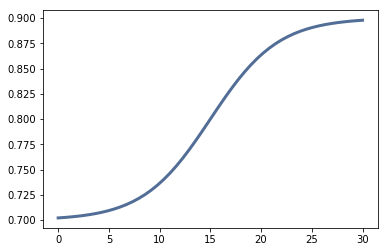

In [17]:
probs = prob_survive(scores)
thinkplot.plot(scores, probs)

In [18]:
class Simulation:
    
    def __init__(self, tournament, agents):
        """Create the simulation:
        
        tournament: Tournament object
        agents: sequence of agents
        """
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """Adds an instrument to the list.
        
        instrument: Instrument object
        """
        self.instruments.append(instrument)
        
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
            
    def plot(self, index, *args, **kwargs):
        """Plot the results from the indicated instrument.
        """
        self.instruments[index].plot(*args, **kwargs)
        
    def run(self, num_steps=100):
        """Run the given number of steps.
        
        num_steps: integer
        """
        # initialize any instruments before starting
        self.update_instruments()
        
        for _ in range(num_steps):
            self.step()
        
    def step(self):
        """Simulate a time step and update the instruments.
        """
        self.tournament.melee(self.agents)
        fits = self.get_fitnesses()
        ps = prob_survive(fits)
        
        # see who dies
        index_dead = self.choose_dead(ps)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, ps)
        self.agents[index_dead] = replacements

        # update any instruments
        self.update_instruments()
        
    def get_fitnesses(self):
        """Returns an array of agent fitnesses."""
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    
    def choose_dead(self, ps):
        """Choose which agents die in the next timestep.
        
        ps: probability of survival for each agent
        
        returns: indices of the chosen ones
        """
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, ps):
        """Choose which agents reproduce in the next timestep.
        
        n: number of choices
        ps: array of weights
        
        returns: sequence of Agent objects
        """
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [19]:
def make_random_agents(n):
    """Make agents with random genotype.
    
    n: number of agents
    
    returns: sequence of agents
    """
    agents = [Agent(np.random.choice(['C', 'D'], size=7)) 
              for _ in range(n)]
    return agents

In [20]:
def make_identical_agents(n, values):
    """Make agents with the given genotype.
    
    n: number of agents
    values: sequence of 'C' and 'D'
    
    returns: sequence of agents
    """
    agents = [Agent(values) for _ in range(n)]
    return agents

In [21]:
class Instrument:
    """Computes a metric at each timestep."""
    
    def __init__(self):
        self.metrics = []
        
    def update(self, sim):
        """Compute the current metric.
        
        Appends to self.metrics.
        
        sim: Simulation object
        """
        # child classes should implement this method
        pass
        
    def plot(self, **options):
        thinkplot.plot(self.metrics, **options)

In [22]:
class MeanFitness(Instrument):
    """Computes mean fitness at each timestep."""
    label = 'Mean Fitness'
    
    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

In [23]:
class Niceness(Instrument):
    """Fraction of cooperation in all genotypes."""
    label = 'Niceness'
        
    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [24]:
class Opening(Instrument):
    """Fraction of agents that cooperate on the first round."""
    label = 'Opening'
        
    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

In [25]:
class Provocability(Instrument):
    """Tendency to defect after opponent defects."""
    label = 'Provocability'
        
    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)

In [26]:
class Forgiveness(Instrument):
    """Tendency to cooperate if opponent cooperates after defecting."""
    label = 'Forgiveness'
        
    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)

In [27]:
tour = Tournament()

agents = make_identical_agents(100, list('DDDDDDD'))
sim = Simulation(tour, agents)

sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Provocability())
sim.add_instrument(Forgiveness())

In [28]:
RandomSeed(17)
sim.run(5000)

14.469780055


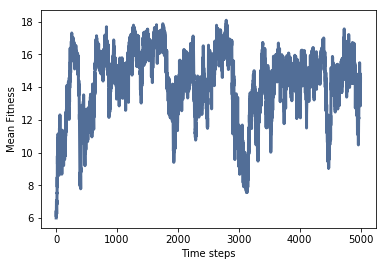

In [29]:
def plot_result(index):
    sim.plot(index)
    instrument = sim.instruments[index]
    print(np.mean(instrument.metrics[1000:]))
    thinkplot.Config(xlabel='Time steps', 
                     ylabel=instrument.label)
          
plot_result(0)

0.636838290427


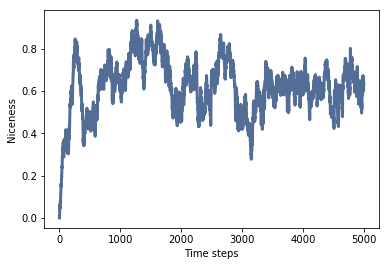

In [30]:
plot_result(1)

0.577348162959


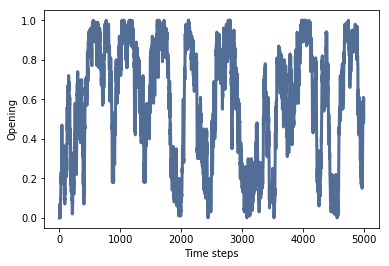

In [31]:
plot_result(2)

0.0540648171291


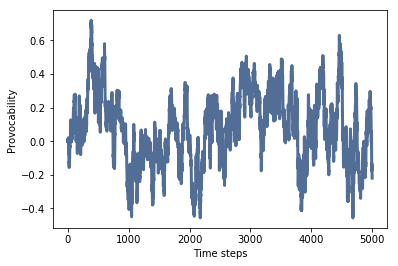

In [32]:
plot_result(3)

-0.0653136715821


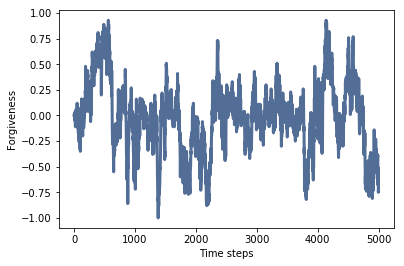

In [33]:
plot_result(4)

In [34]:
for agent in sim.agents:
    print(agent.values)

['C', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'C', 'C', 'C', 'C']
['D', 'C', 'C', 'C', 'C', 'C', 'C']
['D', 'C', 'D', 'C', 'C', 'D', 'D']
['C', 'C', 'C', 'D', 'C', 'D', 'D']
['C', 'D', 'C', 'D', 'C', 'D', 'C']
['D', 'C', 'D', 'C', 'C', 'D', 'D']
['C', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'D', 'C', 'D', 'C']
['D', 'C', 'D', 'C', 'C', 'D', 'D']
['C', 'C', 'C', 'C', 'C', 'C', 'C']
['C', 'D', 'C', 'D', 'C', 'D', 'C']
['D', 'C', 'C', 'C', 'C', 'C', 'C']
['C', 'D', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'C', 'C', 'C', 'C']
['C', 'C', 'C', 'C', 'C', 'C', 'C']
['D', 'C', 'D', 'D', 'C', 'D', 'D']
['C', 'C', 'C', 'C', 'C', 'D', 'C']
['D', 'C', 'D', 'C', 'C', 'D', 'D']
['C', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'D', 'C', 'D', 'D', 'C', 'D']
['D', 'C', 'C', 'C', 'C', 'C', 'C']
['C', 'C', 'C', 'D', 'C', 'D', 'C']
['C', 'C', 'C', 'C', 'C', 'C', 'C']
['C', 'D', 'C', 'D', 'C', 'C', 'D']
['D', 'C', 'C', 'C', 'C', 'D

In [35]:
tft.values

'CCDCDCD'

In [36]:
responses = [''.join(agent.values) for agent in sim.agents]

In [37]:
from pandas import Series
Series(responses).value_counts()

CCCDCDC    23
DCDCCDD    19
CCCCCCC    12
CDCDCDC    10
DCCCCDD     9
DCCCCCC     7
CDCDCCD     4
CDCDDCD     3
CCDCCDD     3
CCCDCDD     2
DCCDCDD     2
DCDDCDD     2
CCCCCDC     1
CCDCCDC     1
CDCDCDD     1
DDCCCDD     1
dtype: int64